# Deep Markov Model for full localization

In [35]:
from tqdm import tqdm

import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from tensorboardX import SummaryWriter
import numpy as np

In [36]:
batch_size = 128#128
epochs = 600
seed = 1
torch.manual_seed(seed)

In [37]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [38]:
#計測モデルとか
def get_ot(st,lmap,max_range):
    dis = torch.sqrt((st[:,0]-lmap[0])**2+(st[:,1]-lmap[1])**2)
    angle = torch.atan2((lmap[1]-st[:,1]),(lmap[0]-st[:,0]))-st[:,2]
    return torch.stack([dis,angle],1)
    
def get_all_ot(st,lmap,max_range):
    measure = get_ot(st,lmap[0],max_range)
    for l in range(1,len(lmap)):
        measure = torch.cat([measure, get_ot(st,lmap[l],max_range)],1)
    return torch.tensor(measure)

In [39]:
landmark_num = 10
start_pos = [2.0,4.0,0.0]#x0,y0,yaw0

In [40]:
landmark_dim = 2
x_dim = landmark_num*2
h_dim = 32 #32
hidden_dim = 32 #32
z_dim = 3
u_dim = 2
t_max = 139

In [41]:
#データの読み込み
transform = transforms.Compose([transforms.ToTensor()])
kwargs = {'batch_size': batch_size, 'num_workers': 1, 'pin_memory': True}

#data loader #とりあえず1時系列分を分身させて食わせてる
#[time,s_x,s_y,s_yaw,uv,ur,ot[1],,,,ot[N]]
data = np.loadtxt('vehicle_motion_data.csv', delimiter=',')
data = torch.tensor([data],dtype=torch.float32)
st = data[0,:,1:(1+z_dim)]
ut = data[0,:,(1+z_dim):(1+z_dim+u_dim)]
ot = data[0,:,(1+z_dim+u_dim):(1+z_dim+u_dim+x_dim)]
t_max = len(ot)

print(st.size())
st=st.repeat(1000,1,1)
ut=ut.repeat(1000,1,1)
ot=ot.repeat(1000,1,1)
print(st.size())


landmark = np.loadtxt('landmark_data.csv',delimiter=',')

train = torch.utils.data.TensorDataset(ot,ut)
train_loader = torch.utils.data.DataLoader(train, shuffle=False,**kwargs)
test = torch.utils.data.TensorDataset(ot,ut)
test_loader = torch.utils.data.DataLoader(test, shuffle=False,**kwargs)

torch.Size([89, 3])
torch.Size([1000, 89, 3])


In [42]:
from pixyz.models import Model
from pixyz.losses import KullbackLeibler, CrossEntropy, IterativeLoss
from pixyz.distributions import Bernoulli, Normal, Deterministic
from pixyz.utils import print_latex

In [43]:
class RNN(Deterministic):
    def __init__(self):
        super(RNN, self).__init__(cond_var=["x","u"], var=["h"])
        self.rnn = nn.GRU(x_dim+u_dim, h_dim, bidirectional=True)
#         self.h0 = torch.zeros(2, batch_size, self.rnn.hidden_size).to(device)
        self.h0 = nn.Parameter(torch.zeros(2, 1, self.rnn.hidden_size))
        self.hidden_size = self.rnn.hidden_size
        
    def forward(self, x, u):
        h0 = self.h0.expand(2, x.size(1), self.rnn.hidden_size).contiguous()
        print(x.size(1))
        print(x.size(),u.size())
        xu=torch.cat([x,u],2)
        print(xu.size())
        h, _ = self.rnn(xu, h0)
        return {"h": h}

In [44]:
# class Generator(Bernoulli):
#     def __init__(self):
#         super(Generator, self).__init__(cond_var=["z"], var=["x"])
#         self.fc1 = nn.Linear(z_dim, hidden_dim)
#         self.fc2 = nn.Linear(hidden_dim, x_dim)
    
#     def forward(self, z):
#         print(z.size()) #[128,3]
#         h = F.relu(self.fc1(z))
#         return {"probs": torch.sigmoid(self.fc2(h))}
class Generator(Normal):
    def __init__(self):
        super(Generator, self).__init__(cond_var=["z"], var=["x"])
    
    def forward(self, z):#計測モデルそのまま
        ot=get_all_ot(z,landmark,[1000,1000])
        return {"loc": ot,"scale":torch.tensor(0.3).to(device)}

In [45]:
class Inference(Normal):
    def __init__(self):
        super(Inference, self).__init__(cond_var=["h", "z_prev", "u"], var=["z"])
        self.fc1 = nn.Linear(z_dim, h_dim*2)
        self.fc2 = nn.Linear(u_dim, h_dim*2)
        self.fc31 = nn.Linear(h_dim*2, z_dim)
        self.fc32 = nn.Linear(h_dim*2, z_dim)
        
    def forward(self, h, z_prev, u):
        h_z = torch.tanh(self.fc1(z_prev))
        h_u = torch.tanh(self.fc2(u))
        h = (1.0/3.0) * (h + h_z + h_u)
        return {"loc": self.fc31(h), "scale": F.softplus(self.fc32(h))}

In [46]:
class Prior(Normal):
    def __init__(self):
        super(Prior, self).__init__(cond_var=["z_prev","u"], var=["z"])
        
    def forward(self, z_prev, u):
        # motion model for two-wheel robot x,y,orient,v,steering
        z = torch.zeros(len(z_prev),z_dim).to(device)
        z[:,2] = z_prev[:,2] + u[:,1]
        z[:,0] = z_prev[:,0] + u[:,0] * torch.cos(z_prev[:,2] + u[:,1])
        z[:,1] = z_prev[:,1] + u[:,0] * torch.sin(z_prev[:,2] + u[:,1])

        return {"loc": z, "scale": torch.tensor(0.3).to(device)}

In [47]:
prior = Prior().to(device)
encoder = Inference().to(device)
decoder = Generator().to(device)
rnn = RNN().to(device)

In [48]:
print(prior)
print("*"*80)
print(encoder)
print("*"*80)
print(decoder)
print("*"*80)
print(rnn)

Distribution:
  p(z|z_{prev},u)
Network architecture:
  Prior(
    name=p, distribution_name=Normal,
    var=['z'], cond_var=['z_prev', 'u'], input_var=['z_prev', 'u'], features_shape=torch.Size([])
  )
********************************************************************************
Distribution:
  p(z|h,z_{prev},u)
Network architecture:
  Inference(
    name=p, distribution_name=Normal,
    var=['z'], cond_var=['h', 'z_prev', 'u'], input_var=['h', 'z_prev', 'u'], features_shape=torch.Size([])
    (fc1): Linear(in_features=3, out_features=64, bias=True)
    (fc2): Linear(in_features=2, out_features=64, bias=True)
    (fc31): Linear(in_features=64, out_features=3, bias=True)
    (fc32): Linear(in_features=64, out_features=3, bias=True)
  )
********************************************************************************
Distribution:
  p(x|z)
Network architecture:
  Generator(
    name=p, distribution_name=Normal,
    var=['x'], cond_var=['z'], input_var=['z'], features_shape=torch.Size(

In [49]:
generate_from_prior = prior * decoder
print(generate_from_prior)
print_latex(generate_from_prior)

Distribution:
  p(x,z|z_{prev},u) = p(x|z)p(z|z_{prev},u)
Network architecture:
  Prior(
    name=p, distribution_name=Normal,
    var=['z'], cond_var=['z_prev', 'u'], input_var=['z_prev', 'u'], features_shape=torch.Size([])
  )
  Generator(
    name=p, distribution_name=Normal,
    var=['x'], cond_var=['z'], input_var=['z'], features_shape=torch.Size([])
  )


<IPython.core.display.Math object>

In [50]:
step_loss = CrossEntropy(encoder, decoder) + KullbackLeibler(encoder, prior)
_loss = IterativeLoss(step_loss, max_iter=t_max, 
                      series_var=["x", "h", "u"], update_value={"z": "z_prev"})
loss = _loss.expectation(rnn).mean()

In [51]:
dmm = Model(loss, distributions=[rnn, encoder, decoder, prior], 
            optimizer=optim.RMSprop, optimizer_params={"lr": 5e-4}, clip_grad_value=10)

In [52]:
print(dmm)
print_latex(dmm)

Distributions (for training): 
  p(h|x,u), p(z|h,z_{prev},u), p(x|z), p(z|z_{prev},u) 
Loss function: 
  mean \left(\mathbb{E}_{p(h|x,u)} \left[\sum_{t=1}^{89} \left(D_{KL} \left[p(z|h,z_{prev},u)||p(z|z_{prev},u) \right] - \mathbb{E}_{p(z|h,z_{prev},u)} \left[\log p(x|z) \right]\right) \right] \right) 
Optimizer: 
  RMSprop (
  Parameter Group 0
      alpha: 0.99
      centered: False
      eps: 1e-08
      lr: 0.0005
      momentum: 0
      weight_decay: 0
  )


<IPython.core.display.Math object>

In [53]:
def data_loop(epoch, loader, model, device, train_mode=False):
    mean_loss = 0
    for idx,[o,u] in enumerate(tqdm(loader)):#batch_idx, (data, _) in enumerate(tqdm(loader)):
        o = o.to(device)
        u = u.to(device)
        batch_size = o.size()[0]
        x = o.transpose(0, 1) #多分転置してるだけ
        u = u.transpose(0, 1)
        z_prev = torch.tensor(start_pos)#初期姿勢
        z_prev = z_prev.repeat(batch_size, 1).to(device)
        if train_mode:
            mean_loss += model.train({'x': x, 'u':u, 'z_prev': z_prev}).item() * batch_size
        else:
            mean_loss += model.test({'x': x, 'u':u, 'z_prev': z_prev}).item() * batch_size
    mean_loss /= len(loader.dataset)
    if train_mode:
        print('Epoch: {} Train loss: {:.4f}'.format(epoch, mean_loss))
    else:
        print('Test loss: {:.4f}'.format(mean_loss))
    return mean_loss

In [54]:
def plot_image_from_latent(batch_size):
    x = []
    z_prev = torch.zeros(batch_size, z_dim).to(device)
    u0 = torch.zeros(batch_size, u_dim).to(device)
    for step in range(t_max):
        samples = generate_from_prior.sample({'z_prev': z_prev,'u':u0})
        x_t = decoder.sample_mean({"z": samples["z"]})
        z_prev = samples["z"]
        x.append(x_t[None, :])
    x = torch.cat(x, dim=0).transpose(0, 1)
    return x

In [55]:
writer = SummaryWriter()

history = {"train_loss":[],"test_loss":[]}

for epoch in range(1, epochs + 1):
    train_loss = data_loop(epoch, train_loader, dmm, device, train_mode=True)
    test_loss = data_loop(epoch, test_loader, dmm, device)

    writer.add_scalar('train_loss', train_loss, epoch)
    writer.add_scalar('test_loss', test_loss, epoch)

    #loss描画用
    history["train_loss"].append(train_loss)
    history["test_loss"].append(test_loss)
    
    sample = plot_image_from_latent(batch_size)[:, None][1,:]
    writer.add_image('Image_from_latent', sample, epoch)

  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


/home/fukku/anaconda3/envs/pixyz/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
 12%|█▎        | 1/8 [00:00<00:04,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1 Train loss: 15118879.0640
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.96it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.24it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


Test loss: 15082710.1200


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 2 Train loss: 15073929.6800
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 15071189.1920


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 3 Train loss: 15076280.5840
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.90it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 15082968.3680


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.57it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 4 Train loss: 15082825.7040
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.90it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.18it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.23it/s]


Test loss: 15086144.4400


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 5 Train loss: 15086770.5680
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.81it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.19it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Test loss: 15087498.1360


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 6 Train loss: 15085625.0640
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 15085817.8960


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 7 Train loss: 15087336.5200
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.90it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 15082777.2720


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 8 Train loss: 15080533.2160
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.25it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


Test loss: 15067144.2560


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 9 Train loss: 15070600.7120
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 15065171.7200


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 10 Train loss: 15062753.8560
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 15053312.5760


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 11 Train loss: 15053491.8560
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 15048075.5840


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 12 Train loss: 15045749.8560
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 15037084.0000


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.37it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 13 Train loss: 15037233.8480
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.19it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Test loss: 15029962.0240


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 14 Train loss: 15029041.2320
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 15020734.0400


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 15 Train loss: 15019226.7280
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.80it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.90it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.18it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Test loss: 15010313.7040


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 16 Train loss: 15009968.6560
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.96it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.24it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Test loss: 15001736.7440


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 17 Train loss: 15000819.6720
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.80it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.90it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14994310.2080


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.61it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 18 Train loss: 14994488.1680
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14987827.2080


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.61it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 19 Train loss: 14986072.2560
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14978334.8880


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 20 Train loss: 14977643.8560
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.84it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.19it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Test loss: 14970131.3520


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 21 Train loss: 14968596.7120
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.90it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.96it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.24it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Test loss: 14960788.5840


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 22 Train loss: 14960640.7280
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14955539.3360


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.61it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 23 Train loss: 14957021.7600
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14949363.4640


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 24 Train loss: 14949838.4960
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.87it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.96it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14942297.2800


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 25 Train loss: 14942451.2480
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.83it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.17it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.23it/s]


Test loss: 14936103.8400


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 26 Train loss: 14937183.9360
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.84it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14930428.3200


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.34it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 27 Train loss: 14932019.8960
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14925831.1840


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 28 Train loss: 14927675.6880
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.24it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Test loss: 14919127.0800


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 29 Train loss: 14921100.3040
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.26it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


Test loss: 14912722.5120


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.14it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 30 Train loss: 14913906.0800
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.32it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.39it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.70it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.75it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Test loss: 14905454.9920


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.18it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 31 Train loss: 14907393.9520
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.67it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.66it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.66it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


Test loss: 14899597.2800


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.12it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 32 Train loss: 14900797.4880
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.66it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.65it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.63it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


Test loss: 14892309.3360


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.16it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 33 Train loss: 14893930.7600
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.62it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:05<00:00,  1.63it/s]


Test loss: 14885950.0880


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.29it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 34 Train loss: 14886944.8240
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.63it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


Test loss: 14879910.4240


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.30it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.30it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 35 Train loss: 14880570.9200
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.30it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.37it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.70it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Test loss: 14873093.0480


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.22it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 36 Train loss: 14874688.2240
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:05<00:00,  1.67it/s]


Test loss: 14867157.6560


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.17it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 37 Train loss: 14868554.3440
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.33it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:05<00:00,  1.66it/s]


Test loss: 14861043.6800


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 38 Train loss: 14862191.4000
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.32it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.32it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.67it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.71it/s]


Test loss: 14855162.4720


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.22it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.18it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 39 Train loss: 14856438.8080
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  1.72it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.74it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.78it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Test loss: 14849664.0080


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.15it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 40 Train loss: 14851195.6160
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.38it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  1.67it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.68it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.69it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Test loss: 14844003.8720


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 41 Train loss: 14846317.5040
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.62it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Test loss: 14837928.0880


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.18it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 42 Train loss: 14839944.7440
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.69it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.63it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


Test loss: 14833052.6160


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.17it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 43 Train loss: 14834242.7120
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.40it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.67it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.71it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Test loss: 14826928.6800


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.26it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 44 Train loss: 14829402.7600
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.69it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.72it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  1.72it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.71it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.78it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Test loss: 14821269.4400


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.18it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 45 Train loss: 14823680.4880
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.40it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.62it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:05<00:00,  1.67it/s]


Test loss: 14815063.3280


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 46 Train loss: 14818010.5360
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.65it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.68it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.69it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.70it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  1.72it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.68it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Test loss: 14810092.8160


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.16it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 47 Train loss: 14812728.2080
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.63it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.71it/s]


Test loss: 14804984.6560


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.16it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 48 Train loss: 14807343.4320
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.67it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.72it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Test loss: 14798806.9920


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 49 Train loss: 14801825.3600
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.65it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.65it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.65it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.56it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


Test loss: 14793175.4720


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.13it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 50 Train loss: 14795856.8640
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.67it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.70it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.70it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.71it/s]


Test loss: 14786978.5200


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:01<00:07,  1.04s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.16it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 51 Train loss: 14789620.1520
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.40it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.65it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


Test loss: 14781915.4880


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.22it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 52 Train loss: 14784104.7760
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.69it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.67it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  1.69it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.66it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.70it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Test loss: 14775483.8080


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:01<00:07,  1.04s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.14it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 53 Train loss: 14777941.9840
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.39it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.71it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.75it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


Test loss: 14769027.9280


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:01<00:07,  1.02s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 54 Train loss: 14771924.3600
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.69it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.71it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.66it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.71it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Test loss: 14763160.0880


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 55 Train loss: 14765871.3680
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.65it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  1.68it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.70it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.73it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


Test loss: 14756263.3040


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.19it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 56 Train loss: 14760030.2480
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.36it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.53it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:05<00:00,  1.57it/s]


Test loss: 14750725.8960


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.17it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 57 Train loss: 14753638.8080
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.65it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.72it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Test loss: 14744999.9520


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:01<00:07,  1.00s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.15it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 58 Train loss: 14748275.8560
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.40it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


Test loss: 14738401.4400


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.15it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 59 Train loss: 14742279.3200
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.63it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:05<00:00,  1.57it/s]


Test loss: 14731668.9680


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.16it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 60 Train loss: 14735609.0080
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.38it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.66it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.71it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.71it/s]


Test loss: 14725482.1200


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.24it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 61 Train loss: 14729647.3200
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.30it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.34it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.61it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


Test loss: 14719164.6400


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.22it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.25it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 62 Train loss: 14722922.3280
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.69it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.73it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  1.66it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.66it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.71it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Test loss: 14713129.1760


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.14it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 63 Train loss: 14716340.1360
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.32it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.34it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.66it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:05<00:00,  1.62it/s]


Test loss: 14706233.6960


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 64 Train loss: 14710145.5440
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  1.67it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.66it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Test loss: 14700469.7280


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 65 Train loss: 14704680.9920
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.39it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.65it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.68it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


Test loss: 14695023.0160


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.14it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 66 Train loss: 14698987.2320
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.67it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Test loss: 14689181.1280


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.16it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 67 Train loss: 14692647.4640
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.38it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.62it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


Test loss: 14683784.3360


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.17it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 68 Train loss: 14687439.9280
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.40it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.63it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.71it/s]


Test loss: 14677268.2320


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.18it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 69 Train loss: 14681947.3280
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.22it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.30it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.38it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:05<00:00,  1.65it/s]


Test loss: 14672049.6160


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:01<00:08,  1.20s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:02<00:06,  1.08s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:05,  1.02s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.12it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 70 Train loss: 14674704.5760
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  1.69it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.73it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.76it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Test loss: 14664565.0240


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.25it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 71 Train loss: 14669476.9040
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.70it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.67it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.66it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.65it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


Test loss: 14659505.8320


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.16it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 72 Train loss: 14662476.2960
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.70it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Test loss: 14653098.4080


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 73 Train loss: 14656532.6400
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.65it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.64it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


Test loss: 14646155.6800


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.16it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 74 Train loss: 14649830.4800
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.70it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.73it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


Test loss: 14639380.9040


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 75 Train loss: 14643270.4960
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.68it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.71it/s]


Test loss: 14632851.2800


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 76 Train loss: 14637377.5120
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.37it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.63it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.68it/s]


Test loss: 14627629.1920


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:01<00:07,  1.00s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 77 Train loss: 14630745.5600
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.33it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:05<00:00,  1.64it/s]


Test loss: 14620450.9600


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.22it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.24it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 78 Train loss: 14624190.3120
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.66it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.68it/s]


Test loss: 14615373.2000


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.19it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 79 Train loss: 14618873.8800
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.37it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.40it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.74it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.91it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  2.05it/s]


Test loss: 14610135.7520


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 80 Train loss: 14612992.3440
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14604118.6960


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 81 Train loss: 14607372.8880
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.86it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14598566.0800


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 82 Train loss: 14601909.3040
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.88it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.96it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14592791.3120


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 83 Train loss: 14596565.5840
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.26it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


Test loss: 14586793.7600


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 84 Train loss: 14591144.0800
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14581910.3040


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 85 Train loss: 14584672.9600
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14575238.8480


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 86 Train loss: 14578911.0640
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.85it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14570476.1120


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.38it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 87 Train loss: 14573794.3280
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14564418.5920


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.38it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 88 Train loss: 14568095.7920
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Test loss: 14559020.9040


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.61it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 89 Train loss: 14563111.2320
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.97it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.26it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


Test loss: 14554008.3440


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 90 Train loss: 14557783.3760
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14548087.3680


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.34it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.40it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 91 Train loss: 14552058.9760
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.80it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.90it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.18it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Test loss: 14542871.4960


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 92 Train loss: 14546162.6480
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.83it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Test loss: 14536937.4000


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.40it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 93 Train loss: 14540822.4720
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.96it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14532303.5760


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 94 Train loss: 14536308.9040
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14527505.0320


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.34it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.40it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.57it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 95 Train loss: 14531180.3440
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.87it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.96it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14522026.3840


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.32it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.39it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 96 Train loss: 14526076.4480
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14517034.9600


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 97 Train loss: 14521315.6080
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.24it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Test loss: 14511885.3600


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 98 Train loss: 14516569.2480
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.78it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.88it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.19it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14507909.5520


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 99 Train loss: 14511590.9200
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14500874.6880


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 100 Train loss: 14504942.5600
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Test loss: 14496266.0880


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.39it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 101 Train loss: 14500673.6880
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.88it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.96it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14491190.8240


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 102 Train loss: 14496086.3200
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14487181.6240


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 103 Train loss: 14491624.2160
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14482308.7760


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.36it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 104 Train loss: 14486585.3120
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.87it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14477813.0480


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 105 Train loss: 14481764.1520
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14472810.9120


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 106 Train loss: 14477569.9760
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.76it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.90it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14468952.9760


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 107 Train loss: 14473340.5200
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.86it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14463983.9680


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 108 Train loss: 14468123.6800
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.77it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.89it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.14it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.21it/s]


Test loss: 14459355.4560


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.40it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 109 Train loss: 14463953.3040
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14456124.8960


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.33it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 110 Train loss: 14460651.2720
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.37it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.61it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:05<00:00,  1.67it/s]


Test loss: 14451877.6640


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 111 Train loss: 14456471.8640
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.36it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.62it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Test loss: 14445467.2160


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 112 Train loss: 14450168.8480
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:05<00:00,  1.60it/s]


Test loss: 14440856.5040


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.18it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 113 Train loss: 14445054.7440
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.73it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.68it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.70it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Test loss: 14435636.7680


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 114 Train loss: 14440370.0960
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.37it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.68it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Test loss: 14430881.5760


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.19it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 115 Train loss: 14435680.4240
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.31it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.39it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.63it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


Test loss: 14426926.5200


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 116 Train loss: 14431436.5760
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.62it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.68it/s]


Test loss: 14422909.2880


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 117 Train loss: 14426863.4480
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.70it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Test loss: 14417887.7520


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 118 Train loss: 14422068.3120
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.36it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.66it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.70it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Test loss: 14414744.8960


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.17it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 119 Train loss: 14418560.1440
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.66it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


Test loss: 14410895.7840


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 120 Train loss: 14414966.3360
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.64it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Test loss: 14407342.3680


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 121 Train loss: 14411953.0800
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.61it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Test loss: 14404152.0880


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.17it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 122 Train loss: 14408582.9440
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.37it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.69it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Test loss: 14401757.4080


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.29it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 123 Train loss: 14406663.0160
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.69it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  1.65it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.69it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Test loss: 14398629.2960


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.31it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 124 Train loss: 14403652.1680
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.71it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.74it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.77it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  1.73it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.77it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  1.79it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.84it/s]


Test loss: 14396135.7360


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.22it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.22it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.25it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 125 Train loss: 14400379.2720
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.37it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.61it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Test loss: 14393473.4400


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.17it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 126 Train loss: 14397008.4720
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.64it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Test loss: 14390659.8640


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.24it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 127 Train loss: 14395012.7440
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.65it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.71it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Test loss: 14387169.5520


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.27it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 128 Train loss: 14391935.3040
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.61it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


Test loss: 14385036.8480


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.19it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 129 Train loss: 14389313.0480
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.61it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.68it/s]


Test loss: 14382971.8720


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.15it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 130 Train loss: 14386652.4720
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.64it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Test loss: 14379860.3120


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.18it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 131 Train loss: 14384050.6080
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:05<00:00,  1.66it/s]


Test loss: 14377772.6320


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.22it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.26it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 132 Train loss: 14381425.9760
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.65it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.70it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  1.74it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.71it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.74it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


Test loss: 14375025.9920


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.15it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 133 Train loss: 14378353.1200
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.65it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.70it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.66it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  1.70it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.70it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.73it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Test loss: 14372140.4640


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 134 Train loss: 14375405.4000
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.65it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.68it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.71it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.73it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Test loss: 14370079.0080


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 135 Train loss: 14373090.8560
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.36it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.61it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:05<00:00,  1.68it/s]


Test loss: 14367162.6720


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.17it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 136 Train loss: 14370931.3360
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.36it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.61it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Test loss: 14364824.4640


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 137 Train loss: 14367941.0160
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.69it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.72it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.75it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  1.73it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.71it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  1.75it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.80it/s]


Test loss: 14361268.6880


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.26it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 138 Train loss: 14364717.3200
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.65it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.68it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.71it/s]


Test loss: 14359499.8240


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.14it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 139 Train loss: 14362989.6720
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  1.70it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.70it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.76it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Test loss: 14357427.7440


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.12it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 140 Train loss: 14360586.0560
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.40it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.63it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:05<00:00,  1.69it/s]


Test loss: 14356291.0480


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 141 Train loss: 14358753.8320
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.66it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  1.67it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.70it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Test loss: 14352210.7200


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.15it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 142 Train loss: 14356137.8000
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.66it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.66it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.71it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Test loss: 14350279.0560


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 143 Train loss: 14354662.8880
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.38it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.39it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.67it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


Test loss: 14349646.2800


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 144 Train loss: 14353048.3360
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.64it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


Test loss: 14347456.9120


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.12it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 145 Train loss: 14351415.8160
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.66it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.71it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Test loss: 14345526.3200


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 146 Train loss: 14350191.7680
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.39it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.66it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  1.73it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.68it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.74it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Test loss: 14344272.1680


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 147 Train loss: 14348337.7600
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.67it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.73it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Test loss: 14342775.2000


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:01<00:07,  1.01s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:02<00:06,  1.01s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 148 Train loss: 14346378.4240
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.69it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Test loss: 14341486.7840


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.19it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 149 Train loss: 14345064.0800
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.67it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.66it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.65it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


Test loss: 14339930.5600


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.22it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.24it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 150 Train loss: 14343993.2720
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.62it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


Test loss: 14339122.8240


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.16it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 151 Train loss: 14342349.5040
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.38it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.65it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.70it/s]


Test loss: 14337267.9920


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:01<00:07,  1.05s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:02<00:06,  1.03s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:05,  1.00s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.14it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 152 Train loss: 14340555.8640
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.68it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Test loss: 14335949.4080


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.18it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 153 Train loss: 14340049.5520
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.63it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Test loss: 14335623.1760


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.16it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 154 Train loss: 14339009.4160
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.37it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.67it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.72it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Test loss: 14333514.2880


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.30it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 155 Train loss: 14336868.1120
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.37it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:05<00:00,  1.67it/s]


Test loss: 14332616.3520


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.18it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 156 Train loss: 14335644.0000
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.68it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  1.73it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.77it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  1.79it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


Test loss: 14330848.4160


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.16it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 157 Train loss: 14334399.2720
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.37it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.71it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


Test loss: 14329718.2320


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.15it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 158 Train loss: 14333223.7600
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.32it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.70it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


Test loss: 14328397.8720


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:01<00:07,  1.10s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:06,  1.03s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.17it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 159 Train loss: 14331618.6080
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.70it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  1.73it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.76it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  1.79it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.83it/s]


Test loss: 14326768.4400


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 160 Train loss: 14330451.1120
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.36it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.70it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.75it/s]


Test loss: 14325339.0640


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.13it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 161 Train loss: 14328994.0160
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.69it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.75it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Test loss: 14324253.0640


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.19it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 162 Train loss: 14328086.3200
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.38it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.68it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.67it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.71it/s]


Test loss: 14323276.6400


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.39it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.57it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 163 Train loss: 14327034.1600
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14322443.2160


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 164 Train loss: 14326156.8720
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.81it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14322145.0960


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.40it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 165 Train loss: 14325290.1840
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.87it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14320127.7520


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 166 Train loss: 14323734.5600
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14319229.5840


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 167 Train loss: 14322844.7040
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.24it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Test loss: 14317887.2880


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 168 Train loss: 14321879.1040
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.88it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.97it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.19it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.24it/s]


Test loss: 14317455.7920


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.35it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.57it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 169 Train loss: 14321368.1600
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14317013.4400


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 170 Train loss: 14320718.7440
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.90it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.18it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Test loss: 14316240.4080


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 171 Train loss: 14320000.1680
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14315362.9120


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 172 Train loss: 14319514.2000
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Test loss: 14315204.6320


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 173 Train loss: 14319110.4400
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.25it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


Test loss: 14315649.7360


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 174 Train loss: 14318737.4240
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14313688.1520


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 175 Train loss: 14317935.2720
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.90it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14314108.3280


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.33it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.39it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 176 Train loss: 14317336.0240
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14313264.6000


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.61it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 177 Train loss: 14317550.2960
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14313160.5040


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 178 Train loss: 14317146.5520
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.86it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Test loss: 14313028.7120


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 179 Train loss: 14316676.6320
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Test loss: 14313006.2480


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.34it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.40it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 180 Train loss: 14316445.2080
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14312799.2480


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 181 Train loss: 14316531.0000
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.24it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Test loss: 14311243.0800


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 182 Train loss: 14315851.9440
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14312034.1840


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.36it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.57it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 183 Train loss: 14315276.0640
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Test loss: 14311285.8560


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 184 Train loss: 14315303.2160
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.80it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.90it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14311786.9600


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 185 Train loss: 14315542.4800
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.25it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


Test loss: 14311818.3200


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.61it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 186 Train loss: 14315571.8880
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14312370.6400


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.36it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 187 Train loss: 14315624.4240
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14311758.3120


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 188 Train loss: 14314740.3280
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.83it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14311562.5760


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 189 Train loss: 14314701.0720
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14310678.9440


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.39it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 190 Train loss: 14314740.0160
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14311690.2160


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 191 Train loss: 14315268.0640
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14310771.6160


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 192 Train loss: 14314873.8800
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14312200.7680


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 193 Train loss: 14315464.8720
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.88it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.97it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14310201.0160


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 194 Train loss: 14314890.7760
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.89it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.97it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14311032.7600


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 195 Train loss: 14314656.9760
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14311347.7280


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.36it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 196 Train loss: 14314947.8960
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14311274.1840


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 197 Train loss: 14315474.5920
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14309466.0000


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 198 Train loss: 14314538.6480
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.87it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14311842.0880


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 199 Train loss: 14314956.9600
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.86it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.96it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14311048.1280


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 200 Train loss: 14313556.8960
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.78it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.89it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.97it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.16it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.22it/s]


Test loss: 14309122.9600


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 201 Train loss: 14314288.4640
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14309827.6800


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 202 Train loss: 14314533.3840
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.96it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14309648.1600


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.38it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 203 Train loss: 14313867.5280
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.24it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Test loss: 14308604.3840


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.39it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.32it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 204 Train loss: 14313613.4480
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14307981.7680


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.32it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.39it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.55it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 205 Train loss: 14312661.2160
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.89it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14308233.8000


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.37it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 206 Train loss: 14313323.1920
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14309407.0800


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 207 Train loss: 14312693.7360
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14307149.7840


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 208 Train loss: 14312099.1200
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Test loss: 14307838.0960


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.40it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 209 Train loss: 14311419.4400
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14306310.6720


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 210 Train loss: 14310360.7920
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14307701.4400


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.37it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 211 Train loss: 14312019.9760
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.81it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.18it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Test loss: 14306443.9440


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 212 Train loss: 14312703.3280
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.79it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.89it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.97it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14306499.2720


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.33it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.40it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 213 Train loss: 14311419.8080
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.86it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.96it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14309823.3680


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 214 Train loss: 14311148.2240
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14308762.7120


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.61it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 215 Train loss: 14311082.7040
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14305195.0160


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 216 Train loss: 14310962.8880
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Test loss: 14306750.9280


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 217 Train loss: 14311861.8000
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.83it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14307245.7040


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 218 Train loss: 14310046.2800
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.85it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14307865.4000


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 219 Train loss: 14310569.1680
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.24it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Test loss: 14304266.2880


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 220 Train loss: 14310023.1760
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14304832.6000


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.39it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 221 Train loss: 14309350.7280
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14305720.0160


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 222 Train loss: 14309851.0640
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14307224.2480


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 223 Train loss: 14310889.1920
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.24it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


Test loss: 14308472.9200


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 224 Train loss: 14310922.2000
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14308366.6480


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.37it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 225 Train loss: 14312134.1840
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14307343.2080


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.61it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 226 Train loss: 14311591.1280
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.89it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.97it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.18it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.21it/s]


Test loss: 14305996.8240


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 227 Train loss: 14311939.6480
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.86it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14308006.1200


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 228 Train loss: 14313257.8240
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.96it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14306442.4080


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 229 Train loss: 14312032.6080
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.71it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.83it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.19it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14309493.6800


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 230 Train loss: 14312367.7920
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.87it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14309300.1520


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 231 Train loss: 14313256.0880
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14307016.7280


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 232 Train loss: 14312961.5440
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14311244.6800


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 233 Train loss: 14313262.2720
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14309820.1120


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.39it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 234 Train loss: 14313886.0960
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14307902.7440


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.38it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 235 Train loss: 14313560.7600
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14306937.2640


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 236 Train loss: 14312508.9440
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.86it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14308455.7760


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 237 Train loss: 14313698.6960
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.76it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.86it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.19it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14307433.8320


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 238 Train loss: 14313840.1760
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.90it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14309990.0720


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 239 Train loss: 14314645.4160
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14311922.2560


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 240 Train loss: 14315099.8240
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14309714.0800


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.36it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 241 Train loss: 14314298.2160
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.79it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.90it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.18it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Test loss: 14311111.8560


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 242 Train loss: 14314341.3520
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14309832.2480


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 243 Train loss: 14314810.1200
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.83it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14311132.8480


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 244 Train loss: 14315174.7200
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.73it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.85it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.17it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.24it/s]


Test loss: 14313746.4720


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 245 Train loss: 14316030.1280
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14314238.9360


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.61it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 246 Train loss: 14316065.2480
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.81it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14309132.7040


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 247 Train loss: 14315032.3600
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.89it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.97it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14308672.8400


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 248 Train loss: 14316193.0880
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14310016.8240


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 249 Train loss: 14317063.9920
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14310000.3040


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.33it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.38it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.57it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 250 Train loss: 14316019.2320
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14312365.5760


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 251 Train loss: 14316725.5760
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.85it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.19it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14317710.4800


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 252 Train loss: 14318266.4080
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.69it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.82it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14314762.2480


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.37it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 253 Train loss: 14317666.6080
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.74it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.86it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.15it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.23it/s]


Test loss: 14310699.3200


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 254 Train loss: 14317840.1600
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Test loss: 14310969.4160


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 255 Train loss: 14317722.5680
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Test loss: 14314011.5840


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 256 Train loss: 14318148.8320
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14312853.1680


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.37it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.57it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 257 Train loss: 14318758.4640
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.27it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


Test loss: 14318723.2480


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 258 Train loss: 14320487.5680
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14317478.8160


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.33it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.40it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 259 Train loss: 14320368.7200
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.77it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.88it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.96it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.19it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Test loss: 14313660.5040


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 260 Train loss: 14319764.6960
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.80it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.88it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.97it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14312596.9440


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.62it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 261 Train loss: 14319201.2880
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.24it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Test loss: 14314548.9600


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 262 Train loss: 14320428.1920
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.17it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.24it/s]


Test loss: 14314162.1360


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.35it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 263 Train loss: 14319905.7440
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14316264.1600


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 264 Train loss: 14321820.3760
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.97it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14314210.9760


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 265 Train loss: 14319739.6640
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.24it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


Test loss: 14317203.1520


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 266 Train loss: 14321849.9040
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14314064.0480


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 267 Train loss: 14321571.3840
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.90it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14314959.5840


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 268 Train loss: 14322169.3120
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14313796.4560


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.37it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 269 Train loss: 14321441.7040
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14316003.3680


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 270 Train loss: 14321679.8800
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.24it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Test loss: 14320686.8160


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 271 Train loss: 14322509.9200
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.75it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.85it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.19it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Test loss: 14321612.9600


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 272 Train loss: 14322399.5120
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14320775.3440


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 273 Train loss: 14322425.9200
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14321142.9840


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 274 Train loss: 14322891.8720
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.90it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.24it/s]


Test loss: 14320795.3280


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.37it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 275 Train loss: 14323608.3520
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14320950.4800


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 276 Train loss: 14324861.4000
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.86it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14318374.7600


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.63it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 277 Train loss: 14324960.8400
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14317969.3680


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 278 Train loss: 14323608.1040
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.24it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Test loss: 14318368.6560


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.38it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 279 Train loss: 14324928.6640
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14318619.7840


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 280 Train loss: 14324325.6800
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.96it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14318684.2400


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 281 Train loss: 14324335.5360
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14317289.9120


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 282 Train loss: 14323160.5200
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14317062.0480


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 283 Train loss: 14322191.5440
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.86it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14316517.5760


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 284 Train loss: 14324317.5120
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.89it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14323915.7920


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 285 Train loss: 14321728.4880
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.88it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Test loss: 14323568.0320


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.57it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 286 Train loss: 14322208.4720
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14324007.3280


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 287 Train loss: 14319512.4240
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.88it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Test loss: 14322239.1680


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 288 Train loss: 14318435.6640
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.89it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14321253.8240


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.39it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 289 Train loss: 14318507.8160
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.86it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14307878.4960


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 290 Train loss: 14310724.7760
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14316731.5920


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.38it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 291 Train loss: 14314217.1520
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.67it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.81it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.19it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Test loss: 14306058.8400


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 292 Train loss: 14311772.8080
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14319576.2480


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 293 Train loss: 14306858.1600
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.96it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14294760.9840


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 294 Train loss: 14301978.5360
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14294286.0880


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 295 Train loss: 14301563.0400
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Test loss: 14295281.4800


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 296 Train loss: 14301640.3360
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.78it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.89it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.97it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14291151.9200


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.36it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 297 Train loss: 14299260.0880
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.80it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14294699.4640


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.61it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 298 Train loss: 14301814.0480
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.78it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.89it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14295207.1440


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.34it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 299 Train loss: 14302442.3360
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.81it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14295171.3360


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 300 Train loss: 14302487.8720
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Test loss: 14295207.5040


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 301 Train loss: 14302125.7440
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.78it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.88it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.18it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.22it/s]


Test loss: 14297248.7200


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 302 Train loss: 14303360.2080
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.85it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14297373.5840


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.39it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 303 Train loss: 14303830.2400
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.90it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14297331.2400


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 304 Train loss: 14304150.4480
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.80it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.90it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14298258.0000


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 305 Train loss: 14304573.5760
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14298463.0000


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.39it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 306 Train loss: 14305629.7840
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14298969.2640


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 307 Train loss: 14305864.5200
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14299255.8960


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 308 Train loss: 14306635.0640
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.18it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Test loss: 14300741.9440


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 309 Train loss: 14307279.4000
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.84it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.97it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14302168.8800


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.33it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.39it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 310 Train loss: 14306949.1520
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.71it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.83it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.18it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Test loss: 14300435.8640


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 311 Train loss: 14307743.0560
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.83it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Test loss: 14306891.4800


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 312 Train loss: 14308840.6320
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.79it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.90it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14309187.5360


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.35it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.57it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 313 Train loss: 14309276.5520
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.82it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14307271.2240


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 314 Train loss: 14308964.7760
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Test loss: 14307536.4160


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 315 Train loss: 14308851.6800
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.69it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.80it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.90it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.18it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.24it/s]


Test loss: 14308260.6880


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 316 Train loss: 14309559.0480
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.77it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.88it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.96it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.18it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.24it/s]


Test loss: 14308783.1520


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 317 Train loss: 14309396.0640
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14309631.9040


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.61it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 318 Train loss: 14310057.7840
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14309948.8240


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 319 Train loss: 14310246.7440
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14306275.7760


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 320 Train loss: 14310212.8400
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14302742.6240


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 321 Train loss: 14309114.7920
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14302443.6000


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.40it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 322 Train loss: 14309327.0240
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.90it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14301930.4400


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 323 Train loss: 14308797.2640
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14302336.8560


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 324 Train loss: 14309078.0640
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14307903.0800


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.37it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 325 Train loss: 14311125.1920
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14301876.3280


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.40it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 326 Train loss: 14310474.1760
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.78it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.89it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.18it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.24it/s]


Test loss: 14305673.2800


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.38it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.55it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 327 Train loss: 14310109.7600
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14306132.6560


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 328 Train loss: 14310679.4000
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.89it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.97it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14305318.6800


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 329 Train loss: 14310119.2160
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.82it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14305579.4240


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 330 Train loss: 14309470.8640
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14304749.5840


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 331 Train loss: 14309125.9600
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.83it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.18it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.23it/s]


Test loss: 14303920.6160


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 332 Train loss: 14309231.7200
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14303838.7680


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 333 Train loss: 14310213.0000
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.79it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.89it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.19it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Test loss: 14302332.7440


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 334 Train loss: 14308699.5920
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14304326.2880


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.36it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 335 Train loss: 14309598.2480
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14305149.6080


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.37it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 336 Train loss: 14310241.4720
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14312418.2240


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 337 Train loss: 14310659.1520
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14311718.3040


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 338 Train loss: 14310549.9680
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.26it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


Test loss: 14310449.3760


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 339 Train loss: 14309919.8880
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Test loss: 14308947.7920


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.39it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 340 Train loss: 14309536.4160
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14309068.6480


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 341 Train loss: 14309657.6320
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.18it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.24it/s]


Test loss: 14309076.2480


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.40it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 342 Train loss: 14309273.5760
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14309417.8640


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 343 Train loss: 14310114.2320
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Test loss: 14309517.5200


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.61it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 344 Train loss: 14310369.7120
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.26it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


Test loss: 14302719.3200


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 345 Train loss: 14310161.1760
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14304224.6640


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 346 Train loss: 14310164.5440
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14303679.3120


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 347 Train loss: 14309956.8160
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14303508.4400


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.37it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 348 Train loss: 14309101.2640
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14304143.0000


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 349 Train loss: 14309402.4160
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.84it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.19it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Test loss: 14303093.4240


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 350 Train loss: 14308735.8800
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.78it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.89it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.97it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.15it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.22it/s]


Test loss: 14304865.0480


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 351 Train loss: 14309078.6080
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14302680.9840


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 352 Train loss: 14308045.4560
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14303887.8480


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 353 Train loss: 14308925.1360
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.87it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14301628.3840


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.39it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 354 Train loss: 14308042.3840
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14302779.0640


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 355 Train loss: 14308159.2960
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14300901.0240


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 356 Train loss: 14306594.0720
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.82it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Test loss: 14302222.1280


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.53it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 357 Train loss: 14307333.4560
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14301696.6720


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.36it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 358 Train loss: 14306076.2080
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.96it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Test loss: 14298648.4160


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.57it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 359 Train loss: 14306303.1440
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.74it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.84it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.17it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.24it/s]


Test loss: 14298413.9840


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 360 Train loss: 14304327.0880
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.82it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14299145.6880


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 361 Train loss: 14304158.7680
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14298965.5440


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 362 Train loss: 14304710.6320
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14297948.3200


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.37it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.57it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 363 Train loss: 14304165.6480
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.89it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14299518.6240


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.40it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 364 Train loss: 14304375.5760
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14299482.4080


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.40it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 365 Train loss: 14304019.5280
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14299599.9200


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 366 Train loss: 14304897.6080
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.88it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.97it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14298647.7680


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 367 Train loss: 14304528.6960
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14300351.6720


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 368 Train loss: 14304174.9280
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14300751.2960


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 369 Train loss: 14304810.6880
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.88it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.96it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14298992.5360


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.57it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 370 Train loss: 14304798.6000
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.77it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.89it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14296469.9920


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.37it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 371 Train loss: 14304144.0080
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14297052.6800


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 372 Train loss: 14303264.4320
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.87it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.96it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14300668.4960


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.56it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 373 Train loss: 14304113.3600
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.81it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14303794.9040


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.33it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.40it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 374 Train loss: 14304003.9280
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.97it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14303356.4320


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.40it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 375 Train loss: 14304458.0080
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.88it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.96it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14302397.4800


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 376 Train loss: 14304601.5120
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.81it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14300937.4240


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 377 Train loss: 14303668.9040
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14301327.3760


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 378 Train loss: 14303406.7440
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.97it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.18it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.23it/s]


Test loss: 14299962.9280


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 379 Train loss: 14302738.6640
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14301666.3200


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 380 Train loss: 14302666.6800
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.77it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.89it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14300435.1120


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 381 Train loss: 14301808.9360
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.83it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14301033.0480


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 382 Train loss: 14302729.1200
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.77it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.88it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:02,  1.97it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.18it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.24it/s]


Test loss: 14299031.7840


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.57it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 383 Train loss: 14302294.4800
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14294910.2800


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.57it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 384 Train loss: 14301126.2960
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.84it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14295414.2960


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 385 Train loss: 14301956.1840
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14294880.6480


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 386 Train loss: 14301170.0960
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.89it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.97it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14293820.8320


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.37it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.57it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 387 Train loss: 14300300.2560
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14295470.5680


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.57it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 388 Train loss: 14300504.0320
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.88it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.97it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14294139.9120


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 389 Train loss: 14299534.9120
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14294759.6400


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 390 Train loss: 14299702.0640
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.90it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14296531.8000


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 391 Train loss: 14300291.0000
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.89it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14293346.2800


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.61it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 392 Train loss: 14299031.7040
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.81it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.89it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.18it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.24it/s]


Test loss: 14292406.0480


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 393 Train loss: 14298349.9040
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.90it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14292492.9600


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 394 Train loss: 14297613.0000
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.89it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.97it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14292691.9120


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.32it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.38it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 395 Train loss: 14297367.9680
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14293820.5120


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 396 Train loss: 14297902.4400
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.77it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.89it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14294157.2000


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 397 Train loss: 14298501.5360
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Test loss: 14291593.4240


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 398 Train loss: 14297261.2640
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.90it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.19it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Test loss: 14291461.4400


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.57it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 399 Train loss: 14296218.3360
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14294779.2400


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 400 Train loss: 14299231.1680
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14299551.0080


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.32it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.39it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.57it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 401 Train loss: 14298406.1120
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.88it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.97it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.19it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Test loss: 14298036.2320


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 402 Train loss: 14298047.1520
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.90it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14297830.3360


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.57it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 403 Train loss: 14298483.0880
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.89it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.97it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Test loss: 14296195.4960


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 404 Train loss: 14297912.2240
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14297184.8160


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 405 Train loss: 14297971.2320
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.82it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14296279.0880


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 406 Train loss: 14297741.8480
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.97it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14297497.0240


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.36it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 407 Train loss: 14298104.8000
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14298715.0320


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 408 Train loss: 14298698.0720
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14292066.9760


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 409 Train loss: 14296813.7440
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.89it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.19it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.24it/s]


Test loss: 14288418.8720


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 410 Train loss: 14295995.1760
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14292830.3600


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 411 Train loss: 14296483.6240
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Test loss: 14290728.7280


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 412 Train loss: 14296478.5040
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14291006.6640


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.36it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 413 Train loss: 14295485.5280
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14292952.7440


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 414 Train loss: 14295972.6720
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.84it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14290519.3520


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.37it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 415 Train loss: 14295575.7440
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.87it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.96it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.16it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.23it/s]


Test loss: 14292320.4560


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 416 Train loss: 14295690.4720
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14291483.0480


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 417 Train loss: 14296087.7120
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.89it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.96it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14290904.6000


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 418 Train loss: 14295238.3360
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.19it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.24it/s]


Test loss: 14290776.6480


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 419 Train loss: 14295062.9520
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.79it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.89it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.97it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.17it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.24it/s]


Test loss: 14291488.1920


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 420 Train loss: 14294487.0960
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.89it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.97it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14291218.9040


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.40it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 421 Train loss: 14294311.1200
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14290360.2560


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 422 Train loss: 14294314.1920
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.90it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14288943.6400


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 423 Train loss: 14293976.9760
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.86it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.96it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Test loss: 14290110.2240


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 424 Train loss: 14293765.0480
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.90it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14289833.6880


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 425 Train loss: 14294214.6080
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.89it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.97it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14291210.7280


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 426 Train loss: 14294441.1680
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.90it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Test loss: 14291258.6880


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.35it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.57it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 427 Train loss: 14293582.6080
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14289364.0240


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.35it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 428 Train loss: 14293478.0800
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.89it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.97it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Test loss: 14286096.6640


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 429 Train loss: 14292443.6960
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.78it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.89it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14291506.9760


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.37it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 430 Train loss: 14294359.6240
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.90it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14287444.8880


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.37it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 431 Train loss: 14292505.1280
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.76it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.88it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.97it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14284992.4320


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 432 Train loss: 14292232.8560
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14287497.9440


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 433 Train loss: 14291053.0960
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.82it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.15it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.21it/s]


Test loss: 14288200.6240


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 434 Train loss: 14290941.3520
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14289839.6480


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 435 Train loss: 14292479.5600
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.87it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14289223.7680


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 436 Train loss: 14292799.9280
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.74it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.86it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.18it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.24it/s]


Test loss: 14287816.0960


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 437 Train loss: 14291932.2240
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.82it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14286764.3360


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 438 Train loss: 14291305.4080
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.72it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.84it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.16it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.22it/s]


Test loss: 14288793.5040


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 439 Train loss: 14291904.9840
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.90it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.24it/s]


Test loss: 14284415.4640


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 440 Train loss: 14290755.3520
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.18it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.24it/s]


Test loss: 14282138.9600


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 441 Train loss: 14290207.1280
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.87it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14289409.2320


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 442 Train loss: 14291710.3440
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.85it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14286005.5440


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 443 Train loss: 14290738.0880
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14287355.0640


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.40it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 444 Train loss: 14289869.5840
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.86it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.16it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.22it/s]


Test loss: 14289088.9280


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 445 Train loss: 14289687.8880
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.25it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


Test loss: 14285535.5840


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 446 Train loss: 14288988.6240
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14287908.9600


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 447 Train loss: 14289508.5120
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14287066.1600


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 448 Train loss: 14288193.9280
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.89it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14288149.8560


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.40it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 449 Train loss: 14289430.9200
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.88it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.96it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14282287.5120


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.36it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 450 Train loss: 14287669.0480
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.79it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.90it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.97it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14284983.3280


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 451 Train loss: 14287893.3120
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14282169.4960


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.61it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 452 Train loss: 14287541.1760
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.81it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14282205.7120


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 453 Train loss: 14286310.6000
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.77it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.88it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.97it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14284154.0720


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.39it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.37it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.37it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.36it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 454 Train loss: 14287695.6880
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.65it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


Test loss: 14284787.2960


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.26it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 455 Train loss: 14288030.3120
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.36it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.38it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:05<00:00,  1.62it/s]


Test loss: 14282500.6640


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.30it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.32it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.33it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.26it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 456 Train loss: 14287940.4160
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.65it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.66it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


Test loss: 14285063.0480


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.31it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.32it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.30it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 457 Train loss: 14287956.0080
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.31it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.39it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.63it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


Test loss: 14283286.9840


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.31it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.33it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.35it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 458 Train loss: 14287738.5680
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.64it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


Test loss: 14284235.4800


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.31it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.34it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 459 Train loss: 14287059.6240
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.30it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.39it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:05<00:00,  1.62it/s]


Test loss: 14281567.0320


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.22it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.31it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.32it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 460 Train loss: 14286241.6160
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.35it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.67it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.80it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  1.95it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  2.07it/s]


Test loss: 14282866.9680


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.34it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.40it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.36it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.33it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.31it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 461 Train loss: 14286452.9600
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.65it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


Test loss: 14285079.2160


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.22it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.26it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 462 Train loss: 14287579.4080
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.63it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


Test loss: 14286139.1600


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.27it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 463 Train loss: 14287135.6480
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.64it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


Test loss: 14281047.8160


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.17it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 464 Train loss: 14285586.3200
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.64it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


Test loss: 14283679.3920


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.27it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 465 Train loss: 14286277.6080
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.64it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


Test loss: 14279877.8400


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.30it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 466 Train loss: 14284553.0320
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.63it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


Test loss: 14279598.5120


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.30it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.32it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.32it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.31it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.32it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 467 Train loss: 14284409.7440
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.65it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


Test loss: 14279313.0800


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.28it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 468 Train loss: 14284557.7520
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.65it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


Test loss: 14277386.5280


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.30it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.30it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 469 Train loss: 14283999.9520
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.34it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.57it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:05<00:00,  1.60it/s]


Test loss: 14283569.2160


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.30it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.30it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.30it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.31it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 470 Train loss: 14285756.4640
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:05<00:00,  1.62it/s]


Test loss: 14283981.0880


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.30it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.30it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.30it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.31it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 471 Train loss: 14285003.7120
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.52it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:05<00:00,  1.55it/s]


Test loss: 14278039.6560


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.22it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.22it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.18it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 472 Train loss: 14283699.0400
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:05<00:00,  1.61it/s]


Test loss: 14282076.9040


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.30it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 473 Train loss: 14283450.2080
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.62it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.63it/s]


Test loss: 14276852.9360


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.30it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 474 Train loss: 14283233.6720
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.55it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:05<00:00,  1.58it/s]


Test loss: 14278984.2080


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.22it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.28it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 475 Train loss: 14282658.7600
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.57it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:05<00:00,  1.60it/s]


Test loss: 14278594.9200


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.30it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.30it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.31it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 476 Train loss: 14282137.7040
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.57it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:05<00:00,  1.60it/s]


Test loss: 14281289.7600


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.22it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.22it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.24it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 477 Train loss: 14282709.7120
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.63it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


Test loss: 14277468.7680


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:02<00:06,  1.01s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.11it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 478 Train loss: 14281070.6000
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.62it/s]


Test loss: 14277416.4240


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.28it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 479 Train loss: 14281443.6880
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.63it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


Test loss: 14275977.0640


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.30it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 480 Train loss: 14279977.5360
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.63it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


Test loss: 14275316.7520


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.29it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 481 Train loss: 14280834.1040
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.64it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


Test loss: 14275751.0000


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.29it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 482 Train loss: 14280240.2000
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.63it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


Test loss: 14276047.4400


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.25it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 483 Train loss: 14280927.9600
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.40it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.61it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.63it/s]


Test loss: 14276058.5360


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.29it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 484 Train loss: 14279934.3840
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.36it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.61it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.63it/s]


Test loss: 14274777.8160


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.28it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 485 Train loss: 14277795.4000
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.63it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


Test loss: 14276492.6800


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.29it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 486 Train loss: 14278926.7680
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.64it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


Test loss: 14274068.9440


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.30it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 487 Train loss: 14279528.5360
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.64it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


Test loss: 14275887.1600


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.29it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 488 Train loss: 14280054.3600
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.65it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


Test loss: 14279343.1920


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.29it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 489 Train loss: 14279648.9360
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.61it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.63it/s]


Test loss: 14273535.4240


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.30it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 490 Train loss: 14278989.2000
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.39it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.38it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.37it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:05<00:00,  1.61it/s]


Test loss: 14271362.7120


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.22it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.29it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 491 Train loss: 14277374.0880
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.64it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


Test loss: 14275947.4960


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.30it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 492 Train loss: 14278113.2240
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.64it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


Test loss: 14275719.5040


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.22it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.29it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 493 Train loss: 14278585.3120
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.63it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


Test loss: 14276606.5360


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.29it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 494 Train loss: 14279316.6960
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.62it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


Test loss: 14273840.9040


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.29it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 495 Train loss: 14277933.1520
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.62it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


Test loss: 14273490.5760


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.30it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 496 Train loss: 14277633.2480
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.64it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


Test loss: 14276880.7200


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.28it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 497 Train loss: 14278124.2240
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:05<00:00,  1.61it/s]


Test loss: 14276625.9360


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.22it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.26it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 498 Train loss: 14278681.5360
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.64it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


Test loss: 14272037.4320


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.27it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 499 Train loss: 14276658.6560
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.63it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


Test loss: 14275082.2880


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.22it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.10it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 500 Train loss: 14277938.4640
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:05<00:00,  1.63it/s]


Test loss: 14271726.3520


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.28it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 501 Train loss: 14276703.1200
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.61it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:05<00:00,  1.64it/s]


Test loss: 14271904.3920


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.29it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 502 Train loss: 14275135.0560
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.63it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


Test loss: 14272305.5600


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.25it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 503 Train loss: 14276394.3760
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.64it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Test loss: 14272533.4400


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.22it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.32it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 504 Train loss: 14276700.6880
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.65it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Test loss: 14271780.2880


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.22it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.32it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 505 Train loss: 14275359.2880
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.31it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.40it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.63it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


Test loss: 14272818.3840


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.22it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.32it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 506 Train loss: 14276805.2080
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.35it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.62it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


Test loss: 14269016.2000


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.26it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 507 Train loss: 14275808.9040
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.68it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.68it/s]


Test loss: 14271387.5680


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.27it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 508 Train loss: 14275486.1840
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.38it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.39it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.66it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


Test loss: 14269940.1600


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.22it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.32it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.33it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 509 Train loss: 14275199.4160
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.66it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.71it/s]


Test loss: 14268785.0400


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.22it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.30it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 510 Train loss: 14274603.1840
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.30it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.38it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.61it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:05<00:00,  1.64it/s]


Test loss: 14268763.4880


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 511 Train loss: 14274815.2400
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.34it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.38it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:06<00:00,  1.37it/s]


Test loss: 14268927.8080


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:01<00:07,  1.12s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:02<00:06,  1.07s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:05,  1.00s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:06<00:00,  1.04it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 512 Train loss: 14274852.1200
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.32it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:06<00:00,  1.36it/s]


Test loss: 14266247.7680


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:01<00:07,  1.09s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:02<00:06,  1.08s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:03<00:05,  1.07s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:04<00:04,  1.04s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:05<00:03,  1.03s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:06<00:02,  1.02s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:07<00:01,  1.01s/it]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 513 Train loss: 14272448.2240
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.35it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:06<00:00,  1.40it/s]


Test loss: 14269429.7840


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:01<00:08,  1.22s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:02<00:07,  1.18s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:03<00:05,  1.17s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:04<00:04,  1.15s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:05<00:03,  1.10s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:06<00:01,  1.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:07<00:00,  1.08it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 514 Train loss: 14272560.0240
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.68it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


Test loss: 14270766.9280


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.30it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.32it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.33it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 515 Train loss: 14273960.4160
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.35it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.47it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:05<00:00,  1.48it/s]


Test loss: 14272502.6160


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:01<00:07,  1.10s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:02<00:06,  1.08s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:03<00:05,  1.08s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:04<00:04,  1.06s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:05<00:03,  1.04s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:06<00:02,  1.05s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:07<00:01,  1.05s/it]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 516 Train loss: 14274245.7920
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.31it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:06<00:00,  1.35it/s]


Test loss: 14266919.4880


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:01<00:08,  1.16s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:02<00:06,  1.10s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:03<00:05,  1.08s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:04,  1.00s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:07<00:01,  1.02s/it]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 517 Train loss: 14272332.2960
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.35it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:06<00:00,  1.36it/s]


Test loss: 14268148.9680


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:01<00:07,  1.06s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:02<00:06,  1.07s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:03<00:05,  1.05s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:04<00:04,  1.02s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:05<00:03,  1.06s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:06<00:02,  1.00s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:07<00:01,  1.03s/it]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 518 Train loss: 14272706.4880
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.34it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.34it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.39it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Test loss: 14269274.2080


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:01<00:07,  1.07s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:02<00:06,  1.05s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:03<00:05,  1.05s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:04<00:04,  1.03s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:05<00:03,  1.02s/it]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:07<00:00,  1.00it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 519 Train loss: 14272565.0400
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Test loss: 14273039.5520


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.28it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 520 Train loss: 14274150.9200
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.36it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.66it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


Test loss: 14269321.6480


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.22it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.31it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.32it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 521 Train loss: 14273305.5120
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.38it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.67it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


Test loss: 14268224.1040


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.31it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.32it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 522 Train loss: 14271104.2160
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.68it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.71it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


Test loss: 14268924.4960


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.30it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.30it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 523 Train loss: 14271920.6800
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.66it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.68it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Test loss: 14267484.2960


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.26it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 524 Train loss: 14272325.0000
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.31it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.40it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.66it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


Test loss: 14266529.9920


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.30it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.32it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 525 Train loss: 14272205.0080
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.39it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.68it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


Test loss: 14266754.5040


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.30it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 526 Train loss: 14270885.5680
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.68it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


Test loss: 14266436.3840


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.22it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.31it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.32it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 527 Train loss: 14269495.4960
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.68it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


Test loss: 14268441.7520


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.25it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 528 Train loss: 14270642.4480
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.68it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


Test loss: 14265160.0400


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.30it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.31it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 529 Train loss: 14268366.9200
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.33it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.64it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


Test loss: 14266004.1200


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.30it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 530 Train loss: 14268500.1360
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.31it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.39it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.64it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.63it/s]


Test loss: 14263955.6240


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.31it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.32it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 531 Train loss: 14268937.5680
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.35it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.63it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:05<00:00,  1.64it/s]


Test loss: 14267073.9520


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.30it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.31it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 532 Train loss: 14269627.2160
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.30it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.38it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.64it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


Test loss: 14266152.8960


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.22it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.30it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.31it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 533 Train loss: 14269531.8160
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.36it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.63it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:05<00:00,  1.62it/s]


Test loss: 14264471.9600


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.30it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 534 Train loss: 14268583.3520
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.65it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


Test loss: 14266135.7200


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.30it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.31it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 535 Train loss: 14268586.5040
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.66it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.69it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.68it/s]


Test loss: 14262204.4960


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.30it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.31it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 536 Train loss: 14268065.6080
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.32it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.40it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.64it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


Test loss: 14263526.0400


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.26it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 537 Train loss: 14268490.3280
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.30it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.39it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.62it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


Test loss: 14260741.4080


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.22it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.30it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 538 Train loss: 14266232.3760
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.64it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


Test loss: 14265307.4560


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.30it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.31it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 539 Train loss: 14268111.6880
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.65it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.64it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


Test loss: 14263219.0880


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.30it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.32it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 540 Train loss: 14268661.8320
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.66it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.68it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.67it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


Test loss: 14261765.8480


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.30it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 541 Train loss: 14267748.8720
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.37it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.64it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


Test loss: 14263343.1600


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.30it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.30it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 542 Train loss: 14267690.6480
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.64it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


Test loss: 14265727.3680


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.31it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 543 Train loss: 14269479.4800
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.34it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.57it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:05<00:00,  1.59it/s]


Test loss: 14264762.3440


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.22it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.30it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 544 Train loss: 14269068.7280
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.60it/s]


Test loss: 14263919.5920


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.30it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.31it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 545 Train loss: 14267966.4160
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.65it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.64it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


Test loss: 14262386.9040


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.22it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.30it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.31it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.32it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 546 Train loss: 14267953.9520
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.67it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.66it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


Test loss: 14260965.9120


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.30it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.31it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 547 Train loss: 14266788.9680
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.40it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.60it/s]


Test loss: 14258929.9280


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.22it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.30it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.31it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.31it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 548 Train loss: 14265817.3920
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.38it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.61it/s]


Test loss: 14260536.7280


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.27it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 549 Train loss: 14265457.2480
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.38it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.63it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


Test loss: 14259864.6000


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.30it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.31it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.32it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 550 Train loss: 14264512.4480
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.64it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.65it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.65it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


Test loss: 14259924.7440


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.27it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 551 Train loss: 14264732.8960
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.63it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.63it/s]


Test loss: 14262481.5600


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.30it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.30it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.31it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 552 Train loss: 14263937.6880
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.31it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.40it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:05<00:00,  1.59it/s]


Test loss: 14260210.4720


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.31it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 553 Train loss: 14263910.0880
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.37it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:05<00:00,  1.60it/s]


Test loss: 14260154.3920


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.28it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 554 Train loss: 14264892.4800
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.53it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:05<00:00,  1.56it/s]


Test loss: 14260110.9920


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.22it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.25it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 555 Train loss: 14264028.7040
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.39it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.61it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.62it/s]


Test loss: 14263000.5920


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.27it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 556 Train loss: 14264865.6240
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.62it/s]


Test loss: 14262477.7600


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.22it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 557 Train loss: 14264479.6480
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.65it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.64it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


Test loss: 14261051.8000


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.28it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 558 Train loss: 14263582.5280
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.66it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.65it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.64it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


Test loss: 14260380.9360


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.26it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.28it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.25it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.28it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 559 Train loss: 14263848.9840
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.38it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:05<00:00,  1.62it/s]


Test loss: 14257205.3120


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.27it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.29it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:02,  1.30it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.15it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 560 Train loss: 14261838.7840
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.70it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.83it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:00,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.13it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.21it/s]


Test loss: 14260205.6240


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.39it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 561 Train loss: 14262901.9200
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.24it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


Test loss: 14259451.1600


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 562 Train loss: 14263152.4480
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.96it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Test loss: 14256098.8800


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 563 Train loss: 14260624.3520
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14256811.4880


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.38it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 564 Train loss: 14261846.9760
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.24it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


Test loss: 14255894.5680


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 565 Train loss: 14260391.3600
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.90it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Test loss: 14256788.2400


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 566 Train loss: 14261687.5040
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14259327.8000


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 567 Train loss: 14262116.9360
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.81it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.19it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14256582.8160


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 568 Train loss: 14260650.5520
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.86it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.96it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14258235.2320


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 569 Train loss: 14262241.0800
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.90it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14256153.0640


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 570 Train loss: 14262118.6640
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.87it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14256706.9920


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 571 Train loss: 14261466.6960
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.88it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.97it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Test loss: 14257793.9360


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.37it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 572 Train loss: 14261138.6480
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.87it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.96it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14256529.1600


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 573 Train loss: 14259850.2560
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.86it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.96it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14254997.8000


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 574 Train loss: 14259387.0240
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.83it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Test loss: 14257197.3360


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 575 Train loss: 14260442.4480
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.24it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Test loss: 14256728.1520


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 576 Train loss: 14259801.9120
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.94it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14256995.4160


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 577 Train loss: 14260556.0000
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.90it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14253894.4480


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 578 Train loss: 14259705.7760
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.24it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


Test loss: 14258210.1440


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 579 Train loss: 14260194.9040
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.85it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.23it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Test loss: 14257956.0000


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 580 Train loss: 14260611.5040
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.80it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.97it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14255123.5920


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 581 Train loss: 14258779.0800
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.89it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.96it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.09it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14255024.8080


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 582 Train loss: 14257613.1280
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.77it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.90it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14255695.4000


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 583 Train loss: 14259119.0560
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.93it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.01it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.17it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.25it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Test loss: 14256542.3440


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 584 Train loss: 14258309.5840
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.25it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


Test loss: 14254296.3760


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 585 Train loss: 14257178.5840
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.92it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  2.00it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14252895.1600


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 586 Train loss: 14257346.2720
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.79it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.90it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.97it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.19it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Test loss: 14253701.7920


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.57it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 587 Train loss: 14257319.4400
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.83it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.21it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14253506.9200


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 588 Train loss: 14256769.9520
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.77it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.88it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.96it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.19it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Test loss: 14253821.6080


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.60it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 589 Train loss: 14257304.8080
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


Test loss: 14253286.7040


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.35it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.58it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 590 Train loss: 14256834.4640
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.90it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.98it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.18it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.24it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Test loss: 14254151.8240


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.56it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 591 Train loss: 14256831.0320
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.77it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.88it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.96it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.02it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.19it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Test loss: 14252450.1360


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.33it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.39it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.44it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.57it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 592 Train loss: 14256450.5680
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:03,  1.99it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.07it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Test loss: 14253405.4080


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.59it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.62it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 593 Train loss: 14256859.2880
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.95it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:00<00:02,  2.03it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.24it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


Test loss: 14250777.4480


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.40it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 594 Train loss: 14257027.3040
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.78it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.89it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.97it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:01<00:01,  2.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  2.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:02<00:00,  2.12it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:03<00:00,  2.19it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Test loss: 14252448.3920


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.49it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.54it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.59it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 595 Train loss: 14257554.2080
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:03,  1.82it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.78it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:02,  1.72it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.69it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  1.72it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.66it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.72it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Test loss: 14254167.1200


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.11it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.20it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 596 Train loss: 14257882.1200
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.50it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.58it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.69it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:02<00:01,  1.65it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.60it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.68it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


Test loss: 14253081.4880


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:05,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.20it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.23it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.24it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:04<00:01,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.22it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 597 Train loss: 14256384.4400
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.55it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.69it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.75it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


Test loss: 14252011.7840


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.14it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.21it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.19it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.19it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 598 Train loss: 14256354.9040
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:01<00:03,  1.51it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.69it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Test loss: 14251697.7440


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.04it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.10it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.19it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 599 Train loss: 14255423.3280
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.43it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.45it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.48it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.52it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.62it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.63it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.69it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Test loss: 14250092.6080


  0%|          | 0/8 [00:00<?, ?it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:06,  1.06it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:05,  1.08it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:04,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:03<00:03,  1.16it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:04<00:02,  1.15it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:05<00:01,  1.13it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:05<00:00,  1.19it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 600 Train loss: 14253720.7600
128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 12%|█▎        | 1/8 [00:00<00:04,  1.41it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 25%|██▌       | 2/8 [00:01<00:04,  1.46it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 38%|███▊      | 3/8 [00:02<00:03,  1.47it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 50%|█████     | 4/8 [00:02<00:02,  1.53it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 62%|██████▎   | 5/8 [00:03<00:01,  1.57it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 75%|███████▌  | 6/8 [00:03<00:01,  1.61it/s]

128
torch.Size([89, 128, 20]) torch.Size([89, 128, 2])
torch.Size([89, 128, 22])


 88%|████████▊ | 7/8 [00:04<00:00,  1.64it/s]

104
torch.Size([89, 104, 20]) torch.Size([89, 104, 2])
torch.Size([89, 104, 22])


100%|██████████| 8/8 [00:04<00:00,  1.71it/s]


Test loss: 14248984.6000


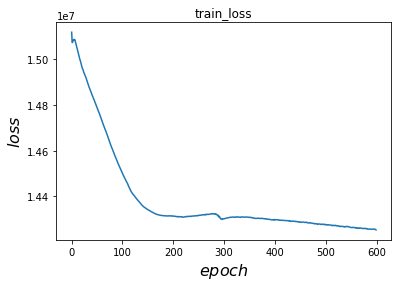

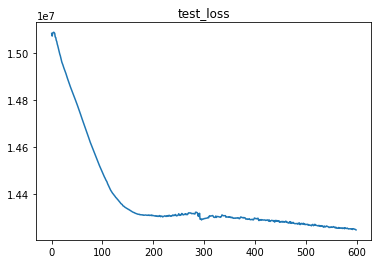

In [59]:
import matplotlib.pyplot as plt

#Loss plot
plt.ylabel('$loss$', fontsize=16)
plt.xlabel('$epoch$', fontsize=16)
ay=plt.gca()
plt.title("train_loss")
plt.plot(range(epochs), [i+0.5 for i in history["train_loss"]])
plt.show()
ay=plt.gca()
plt.title("test_loss")
plt.plot(range(epochs), [i+0.4 for i in history["test_loss"]])
plt.show()

/home/fukku/anaconda3/envs/pixyz/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/home/fukku/anaconda3/envs/pixyz/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


89
torch.Size([1, 89, 20]) torch.Size([1, 89, 2])
torch.Size([1, 89, 22])


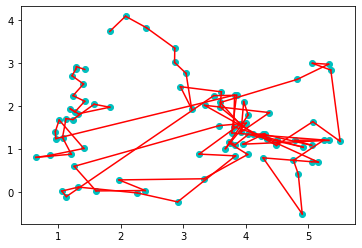

In [58]:

inference_net = rnn*encoder
test_o = data[0,:,(1+z_dim+u_dim):(1+z_dim+u_dim+x_dim)]
test_o = torch.tensor(test_o).reshape(1,len(test_o),x_dim).to(device)
test_u = data[0,:,(1+z_dim):(1+z_dim+u_dim)]
test_u = torch.tensor(test_u).reshape(1,len(test_u),u_dim).to(device)
z_prev = torch.tensor(start_pos).to(device)
infered_result = inference_net.sample({"x":test_o,"z_prev":z_prev,"u":test_u})["z"].to("cpu")
infered_result=infered_result.numpy()

plt.plot(infered_result[:,:, 0], infered_result[:,:, 1], "co")
for i in range(len(infered_result[0])-1):
    plt.plot([infered_result[0][i][0],infered_result[0][i+1][0]],[infered_result[0][i][1],infered_result[0][i+1][1]],"r")
plt.show()